# Bayesian LeNet for COVID-19 binary classification based on CT scans


Data source:

Cohen, Joseph Paul, Paul Morrison, and Lan Dao. "COVID-19 Image Data 
     Collection." arXiv preprint arXiv:2003.11597, March 25, 2020. 



Imports:

In [0]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import numpy as np
import pandas as pd
import os, shutil
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import cv2
import glob
!pip install pytorch-ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall, ConfusionMatrix
from ignite.handlers import ModelCheckpoint


In [0]:
# in order to run this script, you will need to downgrade torchvision and pillow:
import PIL
import torch, torchvision
if torchvision.__version__ == "0.5.0":
  !pip install torchvision==0.4.2
if PIL.__version__ == "7.0.0":
  !pip install pillow==6.2.0

print(torchvision.__version__)
print(PIL.__version__)
# for tracking  cell run times
!pip install ipython-autotime
%load_ext autotime

0.6.0+cu101
6.2.0


Repos to clone:

In [0]:
#%cd content/
!git clone https://github.com/kumar-shridhar/PyTorch-BayesianCNN.git
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

# @article{shridhar2019comprehensive,
#   title={A comprehensive guide to bayesian convolutional neural network with variational inference},
#   author={Shridhar, Kumar and Laumann, Felix and Liwicki, Marcus},
#   journal={arXiv preprint arXiv:1901.02731},
#   year={2019}
# }

%ls

Cloning into 'PyTorch-BayesianCNN'...
remote: Enumerating objects: 570, done.
remote: Counting objects: 100% (570/570), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 1561 (delta 335), reused 471 (delta 247), pack-reused 991
Receiving objects: 100% (1561/1561), 67.79 MiB | 29.44 MiB/s, done.
Resolving deltas: 100% (936/936), done.
Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 1678 (delta 27), reused 44 (delta 15), pack-reused 1616
Receiving objects: 100% (1678/1678), 221.07 MiB | 38.57 MiB/s, done.
Resolving deltas: 100% (801/801), done.
Checking out files: 100% (357/357), done.
covid-chestxray-dataset/  PyTorch-BayesianCNN/  sample_data/
time: 23.1 s


Some Bayesian imports:

In [0]:
%cd PyTorch-BayesianCNN/

from __future__ import print_function

import os
import argparse

import torch
from torch.optim import Adam
from torch.nn import functional as F

import data
import utils
import metrics
import config_bayesian as cfg
from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import WeightedRandomSampler
%cd ../

[Errno 2] No such file or directory: 'PyTorch-BayesianCNN/'
/content/covid-chestxray-dataset
/content
time: 12.5 ms


# Create dataset of COVID-19 CT scans

In [0]:
#create 3 folders. First one is ALL covid, then all OTHER, then the test folder of 60 images. (balanced)
%cd covid-chestxray-dataset/
destpath = ['data/train/covid','data/train/other', 'data/test/covid', 'data/test/other']

if not os.path.isdir(destpath[0]):
  os.makedirs(destpath[0])
if not os.path.isdir(destpath[1]):
  os.makedirs(destpath[1])
if not os.path.isdir(destpath[2]):
  os.makedirs(destpath[2])
if not os.path.isdir(destpath[3]):
  os.makedirs(destpath[3])

/content/covid-chestxray-dataset
time: 5.08 ms


In [0]:
imgpath = './images'
metadata_path='./metadata.csv'
df=pd.read_csv(metadata_path)

#types we're interested in... CT scans & PA (posteroanterior) view
covid_patients=df['finding']=='COVID-19'
CT=df['modality']=='CT' 
PA=df['view']=='PA'


df[covid_patients & CT].shape
df[covid_patients & PA].shape

PA_covid=df[covid_patients & PA]
Others=df[~covid_patients & PA]
covid_files=[files for files in PA_covid['filename']] #filename refers to image name
other_files=[files for files in Others['filename']]


import random
random.seed(123)
test_set_size = 60
half_test = int(test_set_size/2)

test_covid = random.sample(covid_files, half_test) #without replacement
test_other = random.sample(other_files, half_test)

#now we need to remove the test images from the covid and the other images
covid_files = [x for x in covid_files if x not in test_covid]
other_files = [x for x in other_files if x not in test_other]

#there should now be NO overlap of images in these folders.

time: 39.7 ms


In [0]:
for root, dirs, files in os.walk(imgpath):
  for file in files:
    if file in covid_files:
      shutil.copy(os.path.join(root, file),destpath[0])
    if file in other_files:
      shutil.copy(os.path.join(root,file),destpath[1])
    if file in test_covid:
      shutil.copy(os.path.join(root,file),destpath[2])
    if file in test_other:
      shutil.copy(os.path.join(root,file),destpath[3])

time: 162 ms


In [0]:
num_covid = len(os.listdir('data/train/covid'))
num_other = len(os.listdir('data/train/other'))
num_test_covid = len(os.listdir('data/test/covid'))
num_test_other = len(os.listdir('data/test/other'))


print("In the training set, there are {} COVID images and {} OTHER images.\nThe test set is balanced and consists of {} COVID and {} OTHER images.".format(num_covid, num_other, num_test_covid, num_test_other))

In the training set, there are 114 COVID images and 32 OTHER images.
The test set is balanced and consists of 30 COVID and 30 OTHER images.
time: 5.11 ms


# Data class to prepare the COVID images

In [0]:
class CovidDataset(Dataset):
    ''' Defines the Dataset for the Ultrasound Images '''
    def __init__(self, ids, labels, transf):
        super().__init__()

        # Transforms
        self.transforms = transf

        # Images IDS
        self.ids = ids
        self.labels = torch.LongTensor(labels)

        # Calculate len of data
        self.data_len = len(self.ids)

    def __getitem__(self, index):

        # Get an ID of a specific image
        id_img = self.ids[index]

        # Open Image
        img = cv2.imread(id_img)

        # Applies transformations
        if self.transforms:
            img = self.transforms(img)

        label = self.labels[index]

        return (img, label)

    def __len__(self):
        return self.data_len

time: 10.2 ms


### Dataloader


# Prepare dataset 

transformations

In [0]:
def getDataset(dataset):
    '''
    This function is a modification on Shridhar et al's to incorporate the COVID-19 dataset.
    '''
    # Train Images
    train_covid = glob.glob('./data/train/covid/*')
    label_train_covid = [1]*len(train_covid)
    train_other = glob.glob('./data/train/other/*')
    label_train_other = [0]*len(train_other)
    train_images = train_covid + train_other
    train_labels = label_train_covid + label_train_other

    # Test Images
    test_covid = glob.glob('./data/test/covid/*')
    label_test_covid = [1]*len(test_covid)
    test_other = glob.glob('./data/test/other/*')
    label_test_other = [0]*len(test_other)
    test_images = test_covid + test_other
    test_labels = label_test_covid + label_test_other


    #original transforms
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ])
    
    covid_transform = transforms.Compose([
        transforms.ToPILImage(),      
        transforms.Grayscale(num_output_channels=1),                             
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize([0.5381], [0.2061])
    ])
  
    if(dataset == 'COVID'):
        trainset = CovidDataset(ids=train_images, labels=train_labels, transf=covid_transform)
        testset = CovidDataset(ids=test_images, labels=test_labels, transf=covid_transform)
        num_classes = 2
        num_channels = 1 

    if(dataset == 'CIFAR10'):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        num_classes = 10
        num_channels =3

    elif(dataset == 'CIFAR100'):
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
        num_classes = 100
        num_channels = 3
        
    elif(dataset == 'MNIST'):
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        num_classes = 10
        num_channels = 1

    return trainset, testset, num_channels, num_classes

#call this function if including a validation set
def getDataloader(trainset, testset, valid_size, batch_size, num_workers):
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)


    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
        num_workers=num_workers)

    return train_loader, valid_loader, test_loader

# call this function if not including a validation set
def getDataloader_noValid(trainset, testset, batch_size, num_workers): 

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# To set a seed everywhere for this project... call this before training and testing
def seed_everything(seed):
    ''' Set random seed on all environments '''
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

time: 117 ms


# Prepare model 

- using the Bayesian CNN repo. of Shridhar et al. 

In [0]:
import math
import torch.nn as nn
from layers import BBB_LRT_Linear, BBB_LRT_Conv2d
from layers import BBB, BBB_LRT
from layers.BBB import BBBConv, BBBLinear
#from layers import BBB_MCMF_LRT_Linear, BBB_MCMF_LRT_Conv2d
from layers import FlattenLayer, ModuleWrapper


class Bayesian_CNN(ModuleWrapper):
    '''The architecture of LeNet with Bayesian Layers'''

    def __init__(self, outputs, inputs, layer_type='mcmf_lrt', activation_type='softplus'):
        super(Bayesian_CNN, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type

        if layer_type=='mcmf_lrt':
            BBBLinear = BBB_MCMF_LRT_Linear
            BBBConv2d = BBB_MCMF_LRT_Conv2d
        elif layer_type=='lrt':
            BBBLinear = BBB_LRT_Linear
            BBBConv2d = BBB_LRT_Conv2d
        else:
            raise ValueError("Undefined layer_type")
        
        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 6, 5, padding=0, bias=True)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(6, 16, 5, padding=0, bias=True)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BBBConv2d(16, 16, 5, padding=1, bias=True)
        self.act3 = self.act()
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = FlattenLayer(25 * 25 * 16)
        self.fc1 = BBBLinear(25 * 25 * 16, 1000, bias=True)
        self.act3 = self.act()

        self.fc2 = BBBLinear(1000, 500, bias=True)
        self.act4 = self.act()

        self.fc3 = BBBLinear(500, outputs, bias=True)

time: 30.8 ms


In [0]:
# %cd ../
#%cd PyTorch-BayesianCNN/
#%cd content/
!ls

annotations  docs    metadata.csv  requirements.txt  scripts
data	     images  README.md	   SCHEMA.md	     volumes
time: 843 ms


In [0]:
#%cd ../
%cd covid-chestxray-dataset
!ls

[Errno 2] No such file or directory: 'covid-chestxray-dataset'
/content/covid-chestxray-dataset
annotations  docs    metadata.csv  requirements.txt  SCHEMA.md	volumes
data	     images  README.md	   saved_model	     scripts
time: 1.35 s


In [0]:
from __future__ import print_function

import os
import argparse

import torch
import numpy as np
from torch.optim import Adam, lr_scheduler
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix

import data
import utils
import metrics
import config_bayesian as cfg
from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet

# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# how many epochs to train
N_EPOCHS = 30
# how many different networks to train and test?
N_MODELS = 10

def calc_uncertainty_softmax(output):
    prediction = F.softmax(output, dim = 1)
    results = torch.max(prediction, 1 )
    p_hat = np.array(results[0].cpu().detach())
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
    epistemic += epistemic 
    aleatoric = np.mean(p_hat * (1-p_hat), axis = 0)
    aleatoric += aleatoric
    return epistemic, aleatoric

def occam(l):
    return l[-1]/l[0]

def getModel(net_type, inputs, outputs, layer_type, activation_type):
    if (net_type == 'custom'):
        return Bayesian_CNN(outputs, inputs, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, layer_type, activation_type)
    elif (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')


def train_model(net, optimizer, criterion, trainloader, num_ens, beta_type):
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []

    batch_fcW_list = [] #collect sampled weight into batch list
    batch_convW_list = []

    for i, (inputs, labels) in enumerate(trainloader, 1):
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)

        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1)

        which_node = 0
        which_weight = 0
        sampled_fc_weight = net.fc3.W_mu[which_node][which_weight].item()
        which_filter = 0
        which_channel = 0
        which_row = 0
        which_col = 0
        sampled_conv_weight = net.conv1.W_mu[which_filter][which_channel][which_row][which_col].item()

        batch_fcW_list.append(sampled_fc_weight)
        batch_convW_list.append(sampled_conv_weight)

        kl = kl / num_ens
        kl_list.append(kl.item())
        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = metrics.get_beta(i-1, len(trainloader), beta_type, None, None)
        loss = criterion(log_outputs, labels, kl, beta)
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, 1).cpu().detach()
        target = labels.cpu().detach()
        confusion = confusion_matrix(pred.view(-1), target.view(-1))

        accs.append(metrics.acc(log_outputs.data, labels))
        training_loss += loss.cpu().data.numpy()
    average_sampled_fc_weight_across_batches = np.mean(batch_fcW_list)
    average_sampled_conv_weight_across_batches = np.mean(batch_convW_list)
    return training_loss/len(trainloader), np.mean(accs), np.mean(kl_list), batch_fcW_list, batch_convW_list 


# def validate_model(net, criterion, validloader, num_ens=1):
#     """Calculate ensemble accuracy and NLL Loss"""
#     net.train()
#     valid_loss = 0.0
#     accs = []

#     for i, (inputs, labels) in enumerate(validloader):
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
#         kl = 0.0
#         for j in range(num_ens):
#             net_out, _kl = net(inputs)
#             kl += _kl
#             outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

#         log_outputs = utils.logmeanexp(outputs, dim=2)

#         beta = metrics.get_beta(i-1, len(validloader), 0.1)
#         valid_loss += criterion(log_outputs, labels, kl, beta).item()
#         accs.append(metrics.acc(log_outputs, labels))

#     return valid_loss/len(validloader), np.mean(accs)

def test_model(net, criterion, testloader, num_ens=10, beta_type=0.1):
    """Calculate ensemble accuracy and NLL Loss"""
    #net.eval()
    test_loss = 0.0
    accs = []
    epistemic_list = []
    aleatoric_list = []
    for i, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        VI_epistemics = []
        VI_aleatorics = []
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data
            epistemic , aleatoric = calc_uncertainty_softmax(net_out)
            VI_epistemics.append(epistemic)
            VI_aleatorics.append(aleatoric)
        epistemic_list.append(np.mean(VI_epistemics))
        aleatoric_list.append(np.mean(VI_aleatorics))
        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = metrics.get_beta(i-1, len(test_loader), beta_type, None, None)
        test_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

        avg_epistemic_uncertainty = np.round(np.mean(epistemic_list), 5) # across ensembles AND batches
        avg_aleatoric_uncertainty =  np.round(np.mean(aleatoric_list), 5)
    return test_loss/len(testloader), np.mean(accs), len(accs),  avg_epistemic_uncertainty, avg_aleatoric_uncertainty



def run(dataset, net_type):

    # Hyper Parameter settings
    layer_type = cfg.layer_type
    activation_type = cfg.activation_type

    train_ens = cfg.train_ens
    valid_ens = cfg.valid_ens
    n_epochs = N_EPOCHS
    lr_start = cfg.lr_start
    num_workers = cfg.num_workers
    valid_size = 0.2 
    batch_size = 32
    beta_type = cfg.beta_type

    trainset, testset, num_channels, num_classes = getDataset(dataset)
    # train_loader, valid_loader, test_loader = getDataloader(
    #     trainset, testset, valid_size, batch_size, num_workers)
    train_loader, test_loader = getDataloader_noValid(
    trainset, testset, batch_size, num_workers)
    net = getModel(net_type, num_channels, num_classes, layer_type, activation_type).to(device)

    ckpt_dir = f'saved_model/{dataset}/bayesian'
    ckpt_name = f'saved_model/{dataset}/bayesian/model_{net_type}_{layer_type}.pt'

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = metrics.ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    valid_loss_max = np.Inf

    epoch_fc_weight_list = [] 
    epoch_conv_weight_list = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        cfg.curr_epoch_no = epoch

        train_loss, train_acc, train_kl, batch_fcW_list, batch_convW_list = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens, beta_type=beta_type)
        # valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens)
        # lr_sched.step(valid_loss)

        # print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
        #     epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, train_kl))
        epoch_fc_weight_list.append(np.std(batch_fcW_list)) 
        epoch_conv_weight_list.append(np.std(batch_convW_list))
    return net, criterion, train_loader, test_loader, num_channels, num_classes, n_epochs, ckpt_name, train_acc, train_loss, epoch_fc_weight_list, epoch_conv_weight_list


if __name__ == '__main__':
    NET_TYPE = 'custom'
    DATASET = 'COVID'
    SEED = 123

    parser = argparse.ArgumentParser(description = "PyTorch Bayesian Model Training")
    parser.add_argument('--net_type', default=NET_TYPE, type=str, help='model')
    parser.add_argument('--dataset', default=DATASET, type=str, help='dataset = [COVID/MNIST/CIFAR10/CIFAR100]')
    parser.add_argument('-f')
    args = parser.parse_args()

    # set seed
    seed_everything(SEED)

    # metrics to track
    train_accuracies = []
    test_accuracies = []
    generalization_gaps = []
    fc_occams = []
    conv_occams = []
    epistemics = []
    aleatorics = []
    train_losses = []
    test_losses = []

    for j in range(N_MODELS):
        print("Training model \t # {}....".format(j+1))
        net, criterion, train_loader, test_loader, num_channels, num_classes, n_epochs, ckpt_name, train_acc, train_loss, epoch_fc_weight_list, epoch_conv_weight_list = run(args.dataset, args.net_type)
        occam_fc = occam(epoch_fc_weight_list)
        occam_conv = occam(epoch_conv_weight_list)
        print("Done training.")
        print("Testing model \t # {}....".format(j+1))
        test_loss, test_acc, _, avg_epistemic, avg_aleatoric = test_model(net, criterion, test_loader)
        gg = train_acc - test_acc
        print("Occam factor based on fully-connected layer weight: {:6f}, Occam factor based on filter weight: {:6f}".format(occam_fc, occam_conv))
        print("Test accuracy: {}, generalization gap: {:6f}, avg. Epistemic uncertainty.: {:6f}, avg. Aleatoric uncertainty: {:6f}".format(test_acc, gg, avg_epistemic, avg_aleatoric))

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        generalization_gaps.append(gg)
        fc_occams.append(occam_fc)
        conv_occams.append(occam_conv)
        epistemics.append(avg_epistemic)
        aleatorics.append(avg_aleatoric)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    model_number = list(range(1, N_MODELS+1))
    # Create a zipped list of tuples from above lists
    zippedList =  list(zip(model_number, train_accuracies, test_accuracies, generalization_gaps, epistemics, aleatorics, fc_occams, conv_occams, train_losses, test_losses))
    # Create a dataframe from zipped list
    dfObj = pd.DataFrame(zippedList, columns = ['Model Number','Train Accuracy','Test Accuracy' , 'Generalization Gap', 'Avg. Epistemic', 'Avg. Aleatoric', 'Occam factor (FC)', 'Occam factor (Filter)', 'Train Loss', 'Test Loss']) 
    directory_to_save_csv = 'result/'
    if not os.path.exists(directory_to_save_csv):
        os.makedirs(directory_to_save_csv)
    file_name = f"result_dataframe_for_{N_EPOCHS}_epochs.csv"
    dfObj.to_csv(directory_to_save_csv + file_name, index = False, header=True)

Training model 	 # 1....
Epoch: 0 	Training Loss: 950823.5250 	Training Accuracy: 0.6243 	train_kl_div: 8798218.4000
Epoch: 1 	Training Loss: 881401.4125 	Training Accuracy: 0.7153 	train_kl_div: 8658696.0000
Epoch: 2 	Training Loss: 856880.6875 	Training Accuracy: 0.5632 	train_kl_div: 8503264.8000
Epoch: 3 	Training Loss: 837295.4375 	Training Accuracy: 0.7854 	train_kl_div: 8339525.1000
Epoch: 4 	Training Loss: 817879.9750 	Training Accuracy: 0.7410 	train_kl_div: 8171432.5000
Epoch: 5 	Training Loss: 800807.8250 	Training Accuracy: 0.4153 	train_kl_div: 8001737.3000
Epoch: 6 	Training Loss: 783555.8750 	Training Accuracy: 0.5583 	train_kl_div: 7832204.2000
Epoch: 7 	Training Loss: 766653.4750 	Training Accuracy: 0.7556 	train_kl_div: 7664143.1000
Epoch: 8 	Training Loss: 750047.9500 	Training Accuracy: 0.7903 	train_kl_div: 7498377.3000
Epoch: 9 	Training Loss: 733724.8625 	Training Accuracy: 0.7694 	train_kl_div: 7335454.4000
Epoch: 10 	Training Loss: 717707.7125 	Training Accurac

# Frequentist CNN of the same architecture

In [0]:

class Frequentist_CNN(ModuleWrapper):
    '''Custom architecture with Frequentist Layers'''

    def __init__(self, outputs, inputs):
        super(Frequentist_CNN, self).__init__()

        self.num_classes = outputs
        self.num_channels = inputs

        self.layer1 = nn.Sequential(
            nn.Conv2d(inputs, 6, kernel_size=5, stride=1, padding=2),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=1),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        
        self.flatten = FlattenLayer(25 * 25 * 16)
        self.fc1 = nn.Linear(25 * 25 * 16, 1000)
        self.act1 = nn.Softplus()
        self.fc2 = nn.Linear(1000, 500)
        self.act2 = nn.Softplus()
        self.fc3 = nn.Linear(500, outputs)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


time: 35.3 ms


# Training

In [0]:
# Train the model

freq_net = Frequentist_CNN(num_classes, num_channels).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(freq_net.parameters(), lr=0.01)

N_EPOCHS = 30
# Where to save the model:
freq_ckpt_dir = 'saved_model/COVID/model_custom/'
# File name
freq_ckpt_name = 'freq_COVID_CNN.pt'

path_freq_CNN = freq_ckpt_dir + freq_ckpt_name

# If it doesn't exist, make it.
if not os.path.exists(freq_ckpt_dir):
    os.makedirs(freq_ckpt_dir, exist_ok=True)     

avg_train_accuracies = []
avg_train_losses = []
total_step = len(train_loader)
loss_list = []
acc_list = []
# Train
print("Training.....")
for epoch in range(N_EPOCHS):  
    print("Epoch: \t[{}/30]".format(epoch+1))
    for i, (images, labels) in enumerate(train_loader):
        print("Batch: \t{}".format(i+1))
        # Run the forward pass
        #print("Images have shape: {}".format(images.shape))
        images, labels = images.to(device), labels.to(device)
        outputs = freq_net(images).to(device)
        #print("Outputs have shape: {}".format(outputs.shape))
        #print("Labels have shape: {}".format(labels.shape))

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 4 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, n_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    avg_train_accuracies.append(np.mean(acc_list))   
    avg_train_losses.append(np.mean(loss_list))    
freq_net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        print('labels:', labels)
        outputs = freq_net(images).to(device)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 60 test images: {} %'.format((correct / total) * 100))

# Save.
torch.save(freq_net.state_dict(), path_freq_CNN)  
print("Done training.")

Training.....
Epoch: 	[1/30]
Batch: 	1
Batch: 	2
Batch: 	3
Batch: 	4
Epoch [1/30], Step [4/5], Loss: 695.7252, Accuracy: 18.75%
Batch: 	5
Epoch: 	[2/30]
Batch: 	1
Batch: 	2
Batch: 	3
Batch: 	4
Epoch [2/30], Step [4/5], Loss: 3.7863, Accuracy: 15.62%
Batch: 	5
Epoch: 	[3/30]
Batch: 	1
Batch: 	2
Batch: 	3
Batch: 	4
Epoch [3/30], Step [4/5], Loss: 3.1125, Accuracy: 75.00%
Batch: 	5
Epoch: 	[4/30]
Batch: 	1
Batch: 	2
Batch: 	3
Batch: 	4
Epoch [4/30], Step [4/5], Loss: 1.2116, Accuracy: 75.00%
Batch: 	5
Epoch: 	[5/30]
Batch: 	1
Batch: 	2
Batch: 	3
Batch: 	4
Epoch [5/30], Step [4/5], Loss: 0.9055, Accuracy: 84.38%
Batch: 	5
Epoch: 	[6/30]
Batch: 	1
Batch: 	2
Batch: 	3
Batch: 	4
Epoch [6/30], Step [4/5], Loss: 0.6011, Accuracy: 87.50%
Batch: 	5
Epoch: 	[7/30]
Batch: 	1
Batch: 	2
Batch: 	3
Batch: 	4
Epoch [7/30], Step [4/5], Loss: 0.9306, Accuracy: 18.75%
Batch: 	5
Epoch: 	[8/30]
Batch: 	1
Batch: 	2
Batch: 	3
Batch: 	4
Epoch [8/30], Step [4/5], Loss: 0.5259, Accuracy: 78.12%
Batch: 	5
Epoch: 	

# Testing

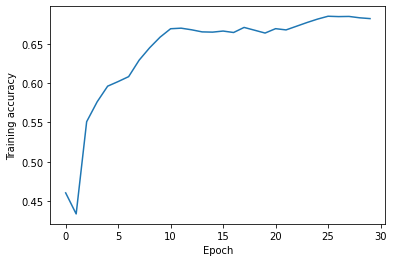

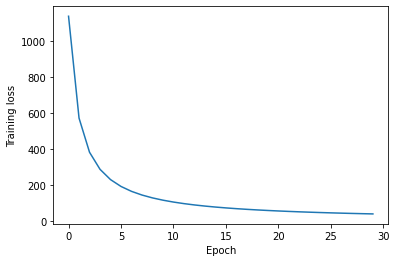

18.201388888888886
The generalization gap for the frequentist custom CNN is 18.201389
time: 245 ms


In [0]:
import matplotlib.pyplot as plt
plt.plot(avg_train_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")
plt.show()
plt.plot(avg_train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

final_train_acc = avg_train_accuracies[-1]*100.
gg = final_train_acc - test_acc
print(gg)

print("The generalization gap for the frequentist custom CNN is {:4f}".format(gg))

torch.Size([224, 224])


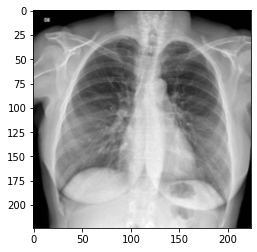

Class:  0 Other
time: 1.52 s


In [0]:
import matplotlib.pyplot as plt
import random

samples, labels = next(iter(train_loader))
s = random.randint(0, len(samples))
sampled_image = samples[s]
print(sampled_image.squeeze(0).shape)
img = sampled_image.squeeze(0)
plt.imshow(img, cmap='gray')
plt.show()
class_item = lambda x : "COVID" if (x==1)  else ("Other")
print("Class: ", labels[s].item(), class_item(labels[s].item()))